# Blueberry yield modelling

This notebook contains the scripts to:

1. Create a plot to compare yield in our database to yield in the litterature


To reproduce the results of this notebook, you will need to install a conda environment containing the packages listed in `requirements.txt`. Because **`weathercan`** and **`rstanarm`** are not available from conda, these packages must be installed manually.

In [1]:
nonconda_packages <- c("weathercan", "rstanarm")
packages_to_install <- nonconda_packages[!(nonconda_packages %in% installed.packages()[,"Package"])]
if(length(packages_to_install)) install.packages(packages_to_install)

In [2]:
library("tidyverse")

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Literature yields

How does yields obtained in our data set compare to the litterature?

Parsed with column specification:
cols(
  Author = col_character(),
  Min = col_double(),
  Max = col_double()
)



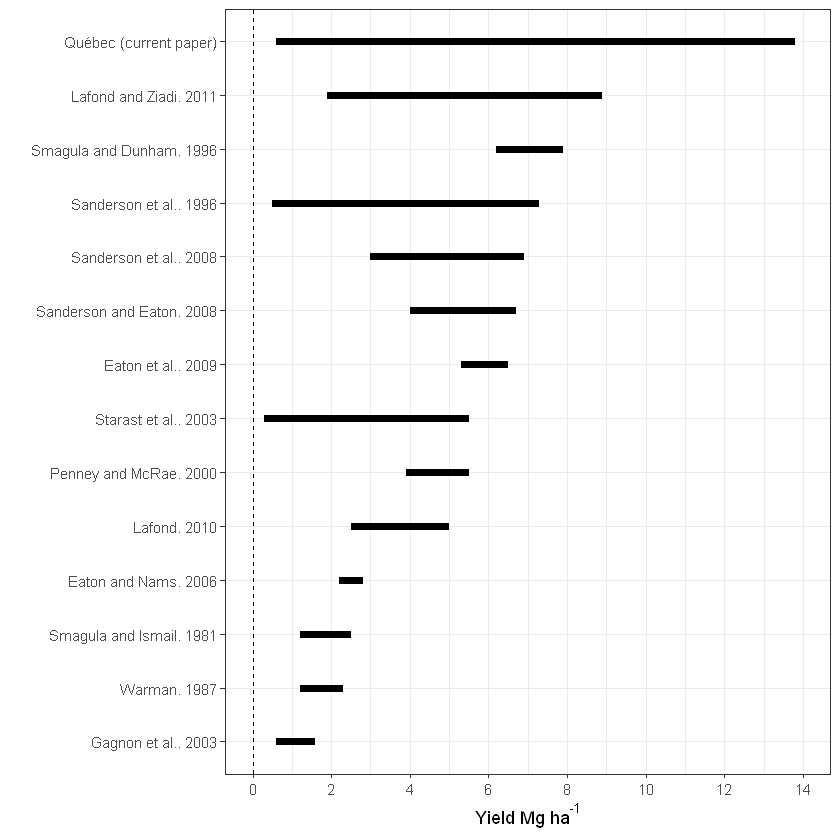

In [3]:
litterature_yields <- read_csv("data/literature-yield.csv")

litterature_yields %>%
  mutate(Author = fct_reorder(Author, Max)) %>%
  ggplot(aes(x = Min, y = Author)) +
  geom_segment(aes(xend = Max, yend = Author), lwd = 2) +
  scale_x_continuous(limits = c(0, 14), breaks = seq(from = 0, to = 15, by = 2)) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = expression("Yield Mg ha"^"-1"), y = "") +
  theme_bw() +
  ggsave("images/litterature-yields.png", height = 3, width = 6, dpi = 300)

## Blueberry data

Data are stored in a single data set.

In [4]:
library("lubridate")
library("tidymodels")
library("skimr")
df_source <- read_csv("data/data.csv", na = c("", "."))
skim(df_source)


Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date


-- Attaching packages -------------------------------------- tidymodels 0.1.0 --

v broom     0.5.5      v rsample   0.0.5 
v dials     0.0.4      v tune      0.0.1 
v infer     0.5.1      v workflows 0.1.1 
v parsnip   0.0.5      v yardstick 0.0.5 
v recipes   0.1.10     

Warning message:
"package 'broom' was built under R version 3.6.3"
Warning message:
"package 'recipes' was built under R version 3.6.3"
Warning message:
"package 'workflows' was built under R version 3.6.3"
-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filter()   masks stats::filter()
x recipes::fixed()  masks stringr::fixed()
x dplyr::lag()      masks stats::lag()
x dials::margin()   masks ggplot2::margin()
x yardstick::spec() masks readr::spec()
x recipes::step()   masks stats::step()

Warning message:
"package 'skimr' was built und

-- Data Summary ------------------------
                           Values   
Name                       df_source
Number of rows             1504     
Number of columns          30       
_______________________             
Column type frequency:              
  character                3        
  numeric                  27       
________________________            
Group variables            None     

-- Variable type: character ----------------------------------------------------
# A tibble: 3 x 8
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
* <chr>             <int>         <dbl> <int> <int> <int>    <int>      <int>
1 Project               0             1     2     6     0       19          0
2 Site                  0             1     7    16     0        6          0
3 Coordinates           0             1    17    17     0        6          0

-- Variable type: numeric ------------------------------------------------------
# A tibble: 27 x 

There are a lot of missing data in the Mo leaf content and the berry dry matter fraction. But oligo-elements are important information. We will proceed to missing data imputation further on. 

Dosage is put on element scale.

In [5]:
df_source <- df_source %>%
  mutate(
    id = 1:nrow(.),
    `P dose (kg/ha)` = `P2O5 dose (kg/ha)` / 2.29,
    `K dose (kg/ha)` = `K2O dose (kg/ha)` / 1.2
  )

## Weather

Weather indices are genereted from data fetched from Environment Canada with the **`weathercan`** package. The **`sp`** package is needed as dependency of **`weathercan`** to look for the closest stations.

In [6]:
library("weathercan")
library("sp")


Attaching package: 'weathercan'


The following object is masked from 'package:dials':

    stations


Warning message:
"package 'sp' was built under R version 3.6.3"


Coordinates are stored by site in `sites.csv`.

In [7]:
sites <- read_csv("data/sites.csv")
df_source <-
  df_source %>%
  left_join(sites, by = "Site")

Parsed with column specification:
cols(
  Site = col_character(),
  Latitude = col_double(),
  Longitude = col_double()
)



### Select weather stations

We have the following Year/Site combinaisons.

In [8]:
year_site <- df_source %>%
  distinct(Year, Site, Latitude, Longitude)

We look for the closest stations with data starting 5 years before observations.

In [9]:
blueberry_stations <- list()
for (i in 1:nrow(year_site)) {
  blueberry_stations[[i]] <- stations_search(
    coords = c(year_site$Latitude[i], year_site$Longitude[i]),
    starts_latest = year_site$Year[i] - 7,
    ends_earliest = year_site$Year[i] + 3,
    dist = 50, interval = "day"
  )
}

We selected the closest stations.

In [10]:
year_site$station_id <- NA
year_site$station_name <- NA
for (i in seq_along(blueberry_stations)) {
  year_site$station_id[i] <- blueberry_stations[[i]]$station_id[1]
  year_site$station_name[i] <- blueberry_stations[[i]]$station_name[1]
}

Station `ST LEON DE LABRECQUE` seems to generate errors. The next closest one is `r blueberry_stations[[3]]$station_name[2]`.

In [11]:
year_site$station_id[3] <- blueberry_stations[[3]]$station_id[2]
year_site$station_name[3] <- blueberry_stations[[3]]$station_name[2]

We will fetch weather by year and station ID.

In [12]:
year_station <- year_site %>% distinct(Year, station_id)

### Fetch weather

We suppose that seasons start on April 1st and end at mid-August. The first loop stores the weather of the year of the experiment. This will be used to asses feature importance.

#### Weather current

These data are the one that occured during the year of the experiment.

```#{r}
weather_current <- list()
for (i in 1:nrow(year_station)) {
weather_current[[i]] <- weather_dl(
station_ids = year_station$station_id[i],
start = paste0(year_station$Year[i], "-04-01"),
end = paste0(year_station$Year[i], "-08-31"),
interval = "day", quiet = TRUE
)
}
```

We unnest the list of lists, the old fashion way.

```#{r}
weather_current <- data.frame(do.call(rbind, weather_current))
save(weather_current, file = "output/weather_current.RData")
```

In [13]:
load("output/weather_current.RData")

#### Weather before

Now for each station, we fetch weather data 5 years before the experiment. These data will be used for prediction. Cells that fetch weather are deactivated since data have already been fetched and saved in a RData file.

We unnest the list of lists.

In [14]:
load("output/weather_before.RData")

### Compute weather indices

#### Weather current

For each month, we compute total **precipitation** and **mean temperature**. 

In [15]:
temp_prec_current <- weather_current %>%
  group_by(station_id, year, month) %>%
  summarise(
    total_precip = sum(total_precip, na.rm = TRUE),
    mean_temp = mean(mean_temp, na.rm = TRUE)
  ) %>%
  pivot_wider(names_from = month, values_from = c(total_precip, mean_temp))

We compute the number of days per month were air temerature falls **under 0 degrees**.

In [16]:
frozen_current <- weather_current %>%
  group_by(station_id, year, month) %>%
  summarise(frozen = sum(mean_temp < 0, na.rm = TRUE)) %>% 
  pivot_wider(names_from = month, values_from = frozen)
names(frozen_current)[-c(1, 2)] <- paste0("frozen_", names(frozen_current)[-c(1, 2)])

While the number of freezing days can affect flowering, the number of days with mean temperature > 26 °C can affect pollination.

In [17]:
toowarm_current <- weather_current %>%
  group_by(station_id, year, month) %>%
  summarise(toowarm = sum(mean_temp >= 26, na.rm = TRUE)) %>% 
  pivot_wider(names_from = month, values_from = toowarm)
names(toowarm_current)[-c(1, 2)] <- paste0("toowarm_", names(toowarm_current)[-c(1, 2)])

Lastly, the degree days are computed between May (julilan day `r yday("2000-05-01")`) and mid-August (julilan day `r yday("2000-08-15")`).

In [18]:
GDD_current <- weather_current %>%
  mutate(julian_day = yday(date)) %>% 
  filter(
    julian_day >= yday("2000-05-01"),
    julian_day <= yday("2000-08-15")
  ) %>%
  group_by(year, station_id) %>% 
  summarise(GDD = sum(mean_temp >= 5, na.rm = TRUE))

All indices in the same table.

In [19]:
weather_indices_current <- temp_prec_current %>%
  left_join(frozen_current, by = c("station_id", "year")) %>% 
  left_join(toowarm_current, by = c("station_id", "year")) %>% 
  left_join(GDD_current, by = c("station_id", "year")) %>%
  ungroup() %>% 
  mutate(year = as.numeric(year)) %>% 
  rename(Year = year)
names(weather_indices_current)[-c(1, 2)] <- paste0("weather_current.", 
                                                   names(weather_indices_current)[-c(1, 2)])

#### Weather before

For each month, we compute total precipitation and mean temperature 5 years before the growing season. 

In [20]:
temp_prec_before <- list()
for (i in 1:nrow(year_station)) {
  temp_prec_before[[i]] <-
    weather_before %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - 5):(year_station$Year[i] - 1)
    ) %>%
    group_by(year, month) %>%
    summarise(
      total_precip = sum(total_precip, na.rm = TRUE),
      mean_temp = mean(mean_temp, na.rm = TRUE)
    ) %>%
    group_by(month) %>%
    summarise(
      total_precip = mean(total_precip, na.rm = TRUE),
      mean_temp = mean(mean_temp, na.rm = TRUE)
    ) %>%
    pivot_wider(names_from = month, values_from = c(total_precip, mean_temp))
}
temp_prec_before <- do.call(rbind, temp_prec_before)

We compute the number of days per month where air temerature falls under 0 degrees, a condition altering flowers.

In [21]:
frozen_before <- list()
for (i in 1:nrow(year_station)) {
  frozen_before[[i]] <- weather_before %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - 5):(year_station$Year[i] - 1),
    ) %>%
    group_by(year, month) %>%
    summarise(frozen = sum(mean_temp <= 0, na.rm = TRUE)) %>%
    group_by(month) %>%
    summarise(frozen = mean(frozen)) %>%
    pivot_wider(names_from = month, values_from = frozen)
}
frozen_before <- do.call(rbind, frozen_before)
names(frozen_before) <- paste0("frozen_", names(frozen_before))

The number of days with mean temperature > 26 °C:

In [22]:
toowarm_before <- list()
for (i in 1:nrow(year_station)) {
  toowarm_before[[i]] <- weather_before %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - 5):(year_station$Year[i] - 1),
    ) %>%
    group_by(year, month) %>%
    summarise(toowarm = sum(mean_temp <= 26, na.rm = TRUE)) %>%
    group_by(month) %>%
    summarise(toowarm = mean(toowarm)) %>%
    pivot_wider(names_from = month, values_from = toowarm)
}
toowarm_before <- do.call(rbind, toowarm_before)
names(toowarm_before) <- paste0("toowarm_", names(toowarm_before))

And GDD.

In [23]:
GDD_before <- c()
for (i in 1:nrow(year_station)) {
  GDD_before[i] <-
    weather_before %>%
    filter(
      station_id == year_station$station_id[i],
      year %in% (year_station$Year[i] - 5):(year_station$Year[i] - 1),
    ) %>%
    mutate(julian_day = yday(date)) %>% 
    filter(
      julian_day >= yday("2000-05-01"),
      julian_day <= yday("2000-08-15")
    ) %>% 
    group_by(year) %>%
    summarise(GDD = sum(mean_temp >= 5, na.rm = TRUE)) %>% 
    summarise(GDD_before = mean(GDD)) %>% 
    pull()
}

All indices in the same table.

In [24]:
weather_indices_before <- year_station %>% 
  bind_cols(temp_prec_before) %>%
  bind_cols(frozen_before) %>% 
  bind_cols(toowarm_before) %>% 
  mutate(GDD_before = GDD_before)
names(weather_indices_before)[-c(1, 2)] <- paste0("weather_before.", 
                                                  names(weather_indices_before)[-c(1, 2)])


### Merge everything

In [25]:
year_station_ <- year_station %>% 
  left_join(weather_indices_current, by = c("Year", "station_id")) %>% 
  left_join(weather_indices_before, by = c("Year", "station_id"))

year_site_ <- year_site %>% 
  left_join(year_station_, by = c("Year", "station_id")) %>% 
  select(-Latitude, -Longitude)

df_weather <- df_source %>%
  left_join(year_site_, by = c("Year", "Site"))

## Compositional preprocess

### Look up missing values

In leaves,

Loading required package: colorspace

Loading required package: grid

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose


Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.


Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues


Attaching package: 'VIM'


The following object is masked from 'package:recipes':


 Variables sorted by number of missings: 
      Variable        Count
 Leaf Mo (ppm) 0.5166223404
 Leaf Mn (ppm) 0.3557180851
 Leaf Zn (ppm) 0.3530585106
 Leaf Fe (ppm) 0.3523936170
 Leaf Cu (ppm) 0.3470744681
 Leaf Al (ppm) 0.1808510638
  Leaf B (ppm) 0.1801861702
    Leaf N (%) 0.0033244681
    Leaf P (%) 0.0033244681
    Leaf K (%) 0.0013297872
   Leaf Ca (%) 0.0006648936
   Leaf Mg (%) 0.0006648936


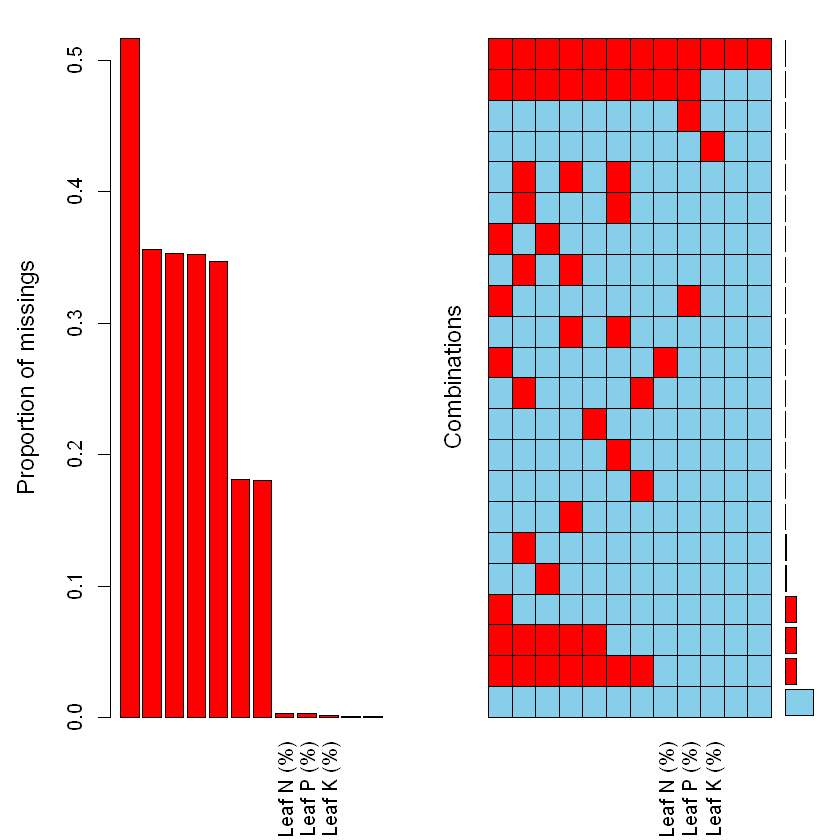

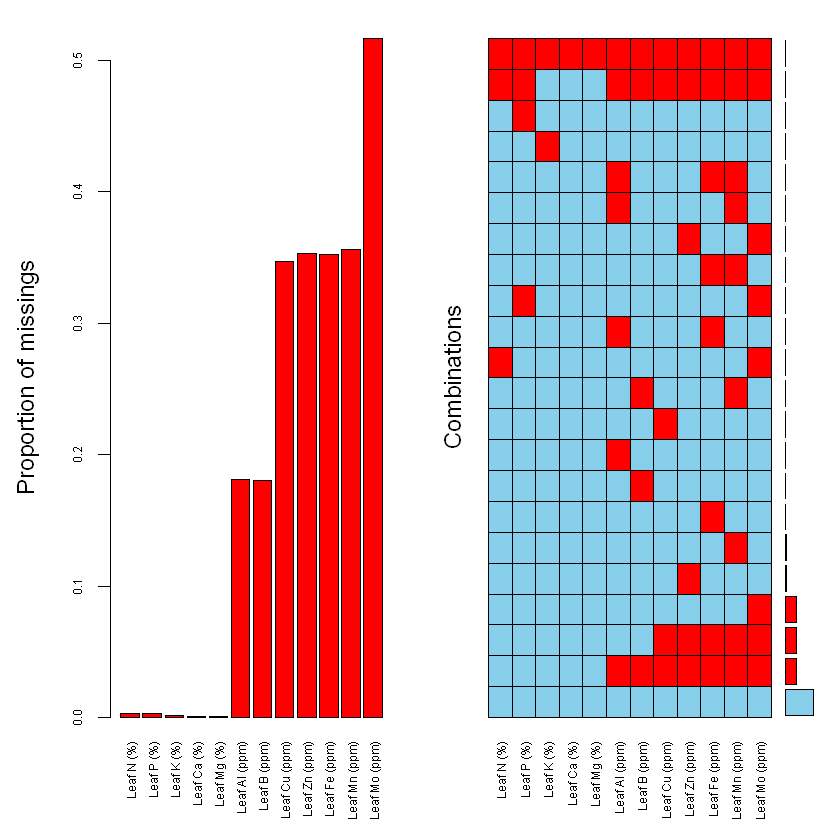

In [26]:
library("VIM")
comp_leaf <- df_source %>%
  select(starts_with("Leaf"))

plot(aggr(comp_leaf, sortVar = TRUE), cex.axis =0.6)

The proportion of NAs in the Mo (~55%), Mn, Zn and Fe columns are very high (~35%) to parse them through imputations. Although Al and B also have pretty high propostions of NAs (~18%), they are important components. They will be kept and imputed.

In soil,


 Variables sorted by number of missings: 
        Variable        Count
  Soil NO3 (ppm) 0.5146276596
  Soil NH4 (ppm) 0.5146276596
  Soil K (mg/kg) 0.0053191489
  Soil P (mg/kg) 0.0006648936
 Soil Ca (mg/kg) 0.0006648936
 Soil Mg (mg/kg) 0.0000000000


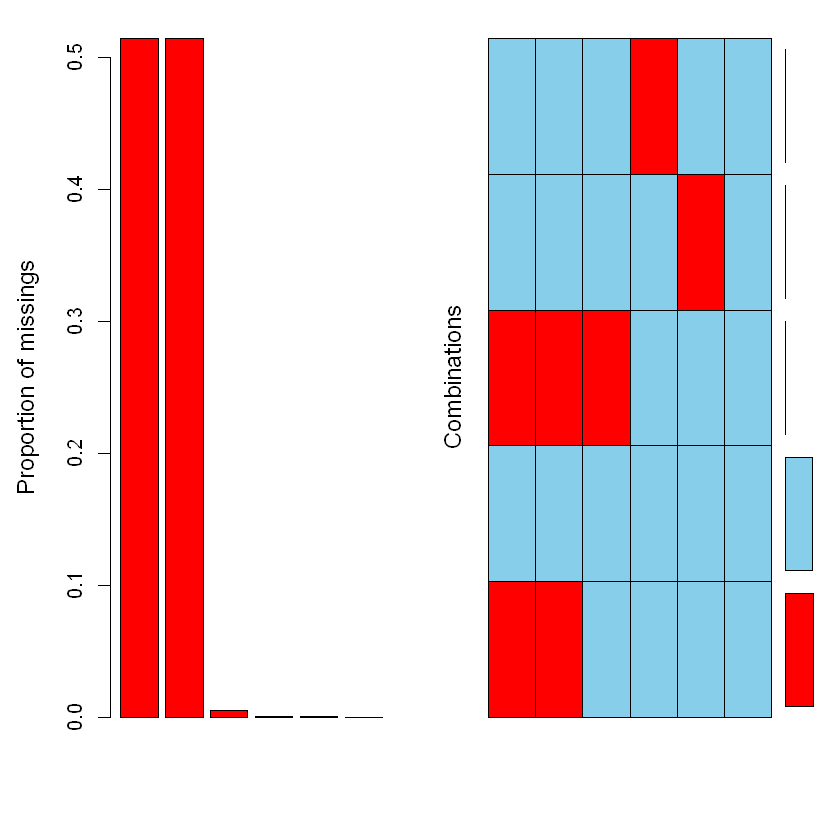

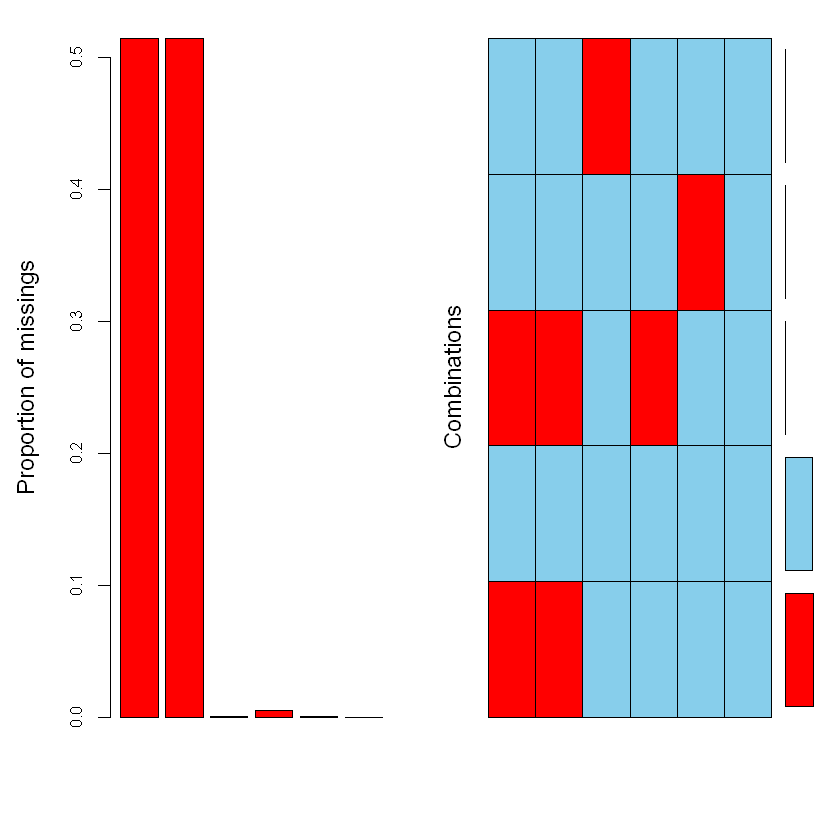

In [27]:
comp_soil <- df_source %>%
  select(starts_with("Soil"))

plot(aggr(comp_soil, sortVar = TRUE), cex.axis = 0.8)

Nitrogen forms have been measured in less than 50%  of the obervations. Unfortunalty, we must rule them out of the analysis. K, P, Ca and Mg are kept.

### Imputations

The imputation is done with a random forest algorithm using the **`mice`** package. Leaves first.

In [28]:
library("mice")

comp_leaf_enough <- comp_leaf %>% 
  select(-`Leaf Mo (ppm)`, -`Leaf Mn (ppm)`, -`Leaf Zn (ppm)`, -`Leaf Cu (ppm)`, -`Leaf Fe (ppm)`)

leaf_comp_names <- names(comp_leaf_enough)
names(comp_leaf_enough) <- c("N", "P", "K", "Ca", "Mg", "Al", "B")

leaf_too_many_nas <- df_source %>% 
  select(id) %>% 
  filter(apply(comp_leaf_enough, 1, function(x) sum(is.na(x)) > 3)) %>% 
  pull()

leaf_imp <- comp_leaf_enough %>% 
  filter(!(df_source$id %in% leaf_too_many_nas)) %>%
  mice(., method = "rf") %>% 
  complete(.)

names(leaf_imp) <- leaf_comp_names

Warning message:
"package 'mice' was built under R version 3.6.3"

Attaching package: 'mice'


The following objects are masked from 'package:base':

    cbind, rbind





 iter imp variable
  1   1  N  P  K  Al  B
  1   2  N  P  K  Al  B
  1   3  N  P  K  Al  B
  1   4  N  P  K  Al  B
  1   5  N  P  K  Al  B
  2   1  N  P  K  Al  B
  2   2  N  P  K  Al  B
  2   3  N  P  K  Al  B
  2   4  N  P  K  Al  B
  2   5  N  P  K  Al  B
  3   1  N  P  K  Al  B
  3   2  N  P  K  Al  B
  3   3  N  P  K  Al  B
  3   4  N  P  K  Al  B
  3   5  N  P  K  Al  B
  4   1  N  P  K  Al  B
  4   2  N  P  K  Al  B
  4   3  N  P  K  Al  B
  4   4  N  P  K  Al  B
  4   5  N  P  K  Al  B
  5   1  N  P  K  Al  B
  5   2  N  P  K  Al  B
  5   3  N  P  K  Al  B
  5   4  N  P  K  Al  B
  5   5  N  P  K  Al  B


Then soil.

In [29]:
comp_soil_enough <- comp_soil %>% 
  select(-`Soil NO3 (ppm)`, -`Soil NH4 (ppm)`)

soil_comp_names <- names(comp_soil_enough)
names(comp_soil_enough) <- c("P", "K", "Ca", "Mg")

soil_too_many_nas <- df_source %>% 
  select(id) %>% 
  filter(apply(comp_soil_enough, 1, function(x) sum(is.na(x)) > 3)) %>% 
  pull()

soil_imp <- comp_soil_enough %>% 
  filter(!(df_source$id %in% soil_too_many_nas)) %>%
  mice(., method = "rf") %>% 
  complete(.)

names(soil_imp) <- soil_comp_names


 iter imp variable
  1   1  P  K  Ca
  1   2  P  K  Ca
  1   3  P  K  Ca
  1   4  P  K  Ca
  1   5  P  K  Ca
  2   1  P  K  Ca
  2   2  P  K  Ca
  2   3  P  K  Ca
  2   4  P  K  Ca
  2   5  P  K  Ca
  3   1  P  K  Ca
  3   2  P  K  Ca
  3   3  P  K  Ca
  3   4  P  K  Ca
  3   5  P  K  Ca
  4   1  P  K  Ca
  4   2  P  K  Ca
  4   3  P  K  Ca
  4   4  P  K  Ca
  4   5  P  K  Ca
  5   1  P  K  Ca
  5   2  P  K  Ca
  5   3  P  K  Ca
  5   4  P  K  Ca
  5   5  P  K  Ca


### Compute balances

Load SBPs.

In [30]:
library("compositions")
sbp_soil <- read_csv("data/sbp-soil.csv")
sbp_leaf <- read_csv("data/sbp-leaf.csv")

Warning message:
"package 'compositions' was built under R version 3.6.3"
Loading required package: tensorA


Attaching package: 'tensorA'


The following object is masked from 'package:base':

    norm


Loading required package: robustbase

Loading required package: bayesm

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: 'compositions'


The following objects are masked from 'package:stats':

    cor, cov, dist, var


The following objects are masked from 'package:base':

    %*%, scale, scale.default


Parsed with column specification:
cols(
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  Fv = col_double()
)

Parsed with column specification:
cols(
  N = col_double(),
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  Al = col_double(),
  B = col_double(),
  Fv = col_double()
)



I have created a small snippet to generate balance definitions from SBPs.

In [31]:
source("lib/ilrDefinition.R")
soil_bal_def <- ilrDefinition(sbp_soil,
                              side = "-+", sep.elem = "",
                              sep.bal = ".", sep.left = "", sep.right = ""
)
leaf_bal_def <- ilrDefinition(sbp_leaf,
                              side = "-+", sep.elem = "",
                              sep.bal = ".", sep.left = "", sep.right = ""
)

Generate leaf balances.

In [32]:
comp_leaf <- leaf_imp %>% 
  mutate(`Leaf Al (%)` = `Leaf Al (ppm)` / 1e4,
         `Leaf B (%)` = `Leaf B (ppm)` / 1e4,) %>% 
  select(-`Leaf Al (ppm)`, -`Leaf B (ppm)`) %>% 
  mutate(Fv = 100 - `Leaf N (%)` - `Leaf P (%)` - `Leaf K (%)` -
           `Leaf Ca (%)` - `Leaf Mg (%)` - `Leaf Al (%)` - `Leaf B (%)`)
bal_leaf <- ilr(comp_leaf, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()
names(bal_leaf) <- paste0("Leaf_", leaf_bal_def)

bal_leaf <- bal_leaf %>% 
  mutate(id = df_source$id[!(df_source$id %in% leaf_too_many_nas)])

Generate soil balances.

In [33]:
comp_soil <- soil_imp %>% 
  mutate(Fv = 1e6 - `Soil Ca (mg/kg)` - `Soil P (mg/kg)` - `Soil K (mg/kg)` - `Soil Mg (mg/kg)`)
bal_soil <- ilr(comp_soil, V = gsi.buildilrBase(t(sbp_soil))) %>% 
  data.frame()
names(bal_soil) <- paste0("Soil_", soil_bal_def)

bal_soil <- bal_soil %>% 
  mutate(id = df_source$id)

### Merge variables to a table for modelling

Tables for weather, soil balances et leaf balances are merged to a single table which will be used for statistical and predictive modelling.

In [34]:
df_ <- df_weather %>%
  select(-starts_with(c("Leaf", "Soil"))) %>%
  left_join(bal_leaf, by = "id") %>% 
  left_join(bal_soil, by = "id")

## Statistical modelling

I will first use a frequential modelling framework to make sure everything works, then use a bayesian framework to obtain posterior effects. I'm keeping only variables of interest.

In [35]:
df_stats <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_current"),
    # Random effects
    Year, Site, Block
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

In [36]:
linmod_formula <- yield ~ doseN + doseP + doseK + pH +
  Leaf_Fv.BAlMgCaKPN + Leaf_Al.BMgCaKPN + Leaf_B.MgCaKPN + 
  Leaf_MgCaK.PN + Leaf_P.N + Leaf_MgCa.K + Leaf_Mg.Ca +
  Soil_Fv.MgCaKP + Soil_MgCaK.P + Soil_MgCa.K + Soil_Mg.Ca +
  weather_current.total_precip_04 + weather_current.total_precip_05 + weather_current.total_precip_06 +
  weather_current.total_precip_07 + weather_current.total_precip_08 +
  weather_current.mean_temp_04 + weather_current.mean_temp_05 + weather_current.mean_temp_06 +
  weather_current.mean_temp_07 + weather_current.mean_temp_08 #+ 
#weather_current.frozen_04 +
#weather_current.frozen_05 + weather_current.frozen_06 +
#weather_current.frozen_07 + weather_current.frozen_08
#weather_current.toowarm_04 + weather_current.toowarm_05 + 
#weather_current.toowarm_06# +
#weather_current.toowarm_07# +
#weather_current.toowarm_08 +
#weather_current.GDD

df_stats_recipe <-
  df_stats %>%
  recipe(linmod_formula) %>%
  step_log(all_outcomes(), base = 10) %>% 
  step_normalize(-all_outcomes(), all_numeric()) %>%
  prep()

### Frequential framework

In [37]:
lm_freq <- lm(linmod_formula, data = juice(df_stats_recipe))

Parsed with column specification:
cols(
  term = col_character(),
  english = col_character()
)



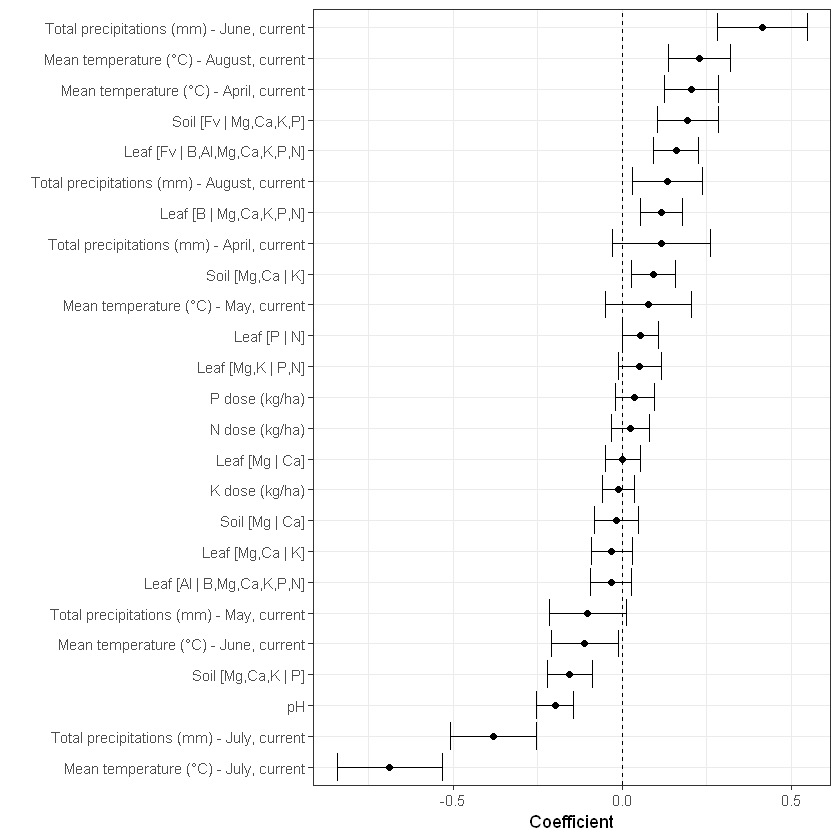

In [38]:
translate_df <- read_csv("data/translate_names.csv")

tidy(lm_freq, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  left_join(translate_df, by = "term") %>%
  mutate(english = fct_reorder(english, estimate)) %>%
  ggplot(aes(estimate, english)) +
  geom_vline(xintercept = 0, linetype = 2) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high)) +
  labs(x = "Coefficient", y = "") +
  theme_bw() +
  ggsave("images/modlin-freq.png", width = 6, height = 6, dpi = 300)

### Bayesian framework

In [39]:
library("rstanarm")
library("tidybayes")
library("bayesplot")

lm_bayes <- stan_glm(
  linmod_formula,
  data = juice(df_stats_recipe),
  family = gaussian(),
  prior = normal(0, 10),
  prior_intercept = normal(0, 10),
  iter = 4000,
  warmup = 1000,
  cores = 4,
  seed = 8578234
)

Warning message:
"package 'rstanarm' was built under R version 3.6.3"
Loading required package: Rcpp


Attaching package: 'Rcpp'


The following object is masked from 'package:rsample':

    populate


rstanarm (Version 2.19.3, packaged: 2020-02-11 05:16:41 UTC)

- Do not expect the default priors to remain the same in future rstanarm versions.

Thus, R scripts should specify priors explicitly, even if they are just the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

options(mc.cores = parallel::detectCores())

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: 'rstanarm'


The following object is masked from 'package:compositions':

    R2


Warning message:
"package 'tidybayes' was built under R version 3.6.3"

Attaching package: 'tidybayes'


The following object is masked from 'package:tune':

    parameters


The f

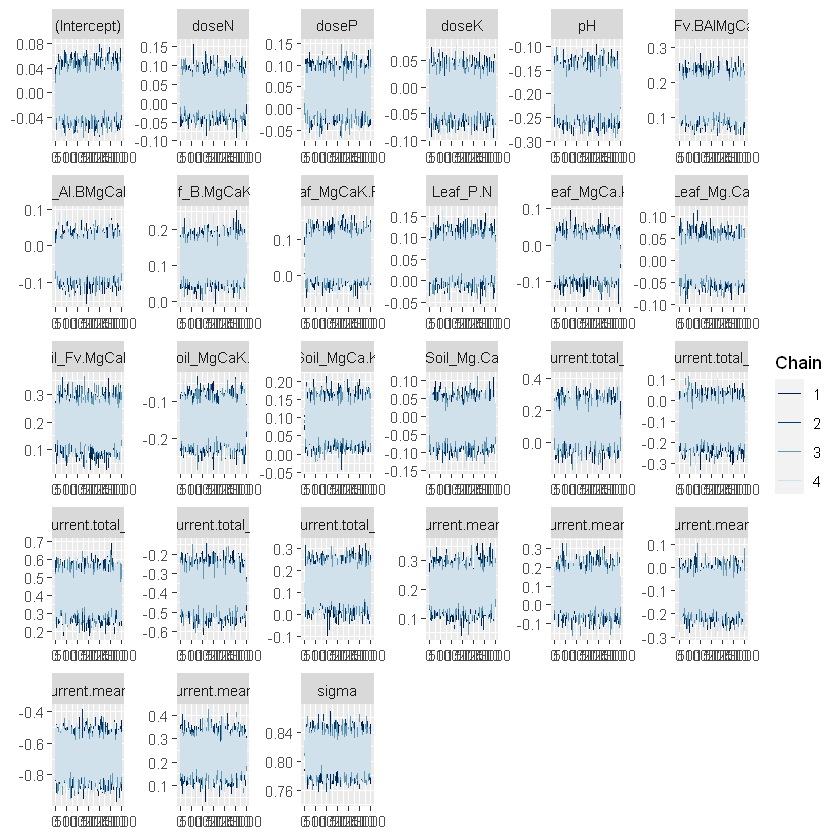

In [40]:
mcmc_trace(lm_bayes)

All caterpillars have constant noise. This is what we want.

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



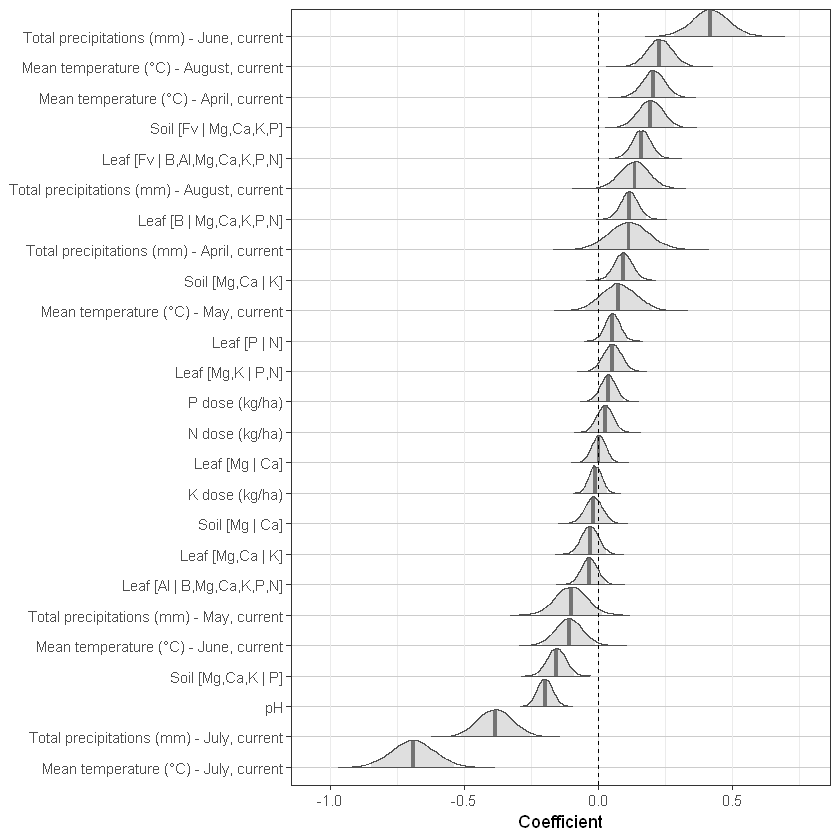

In [41]:
lm_summary <- tibble(
  term = names(lm_bayes$coefficients)[-1],
  coefficient = lm_bayes$coefficients[-1]
) %>%
  left_join(translate_df, by = "term")

color_scheme_set("gray")
mcmc_areas(
    lm_bayes,
    prob = 0.95,
    pars = lm_summary$term[order(lm_summary$coefficient, decreasing = FALSE)],
    area_method = "equal height"
  ) +
  geom_vline(xintercept = 0, linetype = 2) +
  labs(x = "Coefficient") +
  scale_y_discrete(
    labels = lm_summary$english[order(lm_summary$coefficient, decreasing = FALSE)]
  ) +
  theme_bw() +
  theme(panel.grid.major.y = element_line(colour = "grey80")) +
  ggsave("images/modlin-bayes.png", width = 8, height = 5, dpi = 300)

## Predictive modelling

Split training and testing data randomly across all observations.

In [42]:
set.seed(59413) # random.org

Molelling yield from the NPK dosage and soil conditions

In [43]:
df_npk <- df_ %>%
  select(
    `Berry yield (kg/ha)`,
    `N dose (kg/ha)`,
    `P dose (kg/ha)`,
    `K dose (kg/ha)`,
    `pH H2O`,
    starts_with("Leaf_"),
    starts_with("Soil_"),
    starts_with("weather_before")
  ) %>%
  rename(
    yield = `Berry yield (kg/ha)`,
    doseN = `N dose (kg/ha)`,
    doseP = `P dose (kg/ha)`,
    doseK = `K dose (kg/ha)`,
    pH = `pH H2O`
  ) %>%
  drop_na()

In [44]:
df_npk <- df_npk %>% 
  select(-weather_before.frozen_04, -weather_before.frozen_05,
         -weather_before.frozen_06, -weather_before.frozen_07, -weather_before.frozen_08,
         -weather_before.toowarm_04, -weather_before.toowarm_05, -weather_before.toowarm_06,
         -weather_before.toowarm_08, -weather_before.mean_temp_07)

Train / test split.

In [45]:
npk_split <- initial_split(df_npk, prop = 3 / 4)

npk_train <- training(npk_split)
npk_test <- testing(npk_split)

Preprocessing recipe.

In [46]:
npk_recipe <- npk_train %>%
  recipe(yield ~ .) %>%
  #step_nzv(all_numeric()) %>% 
  #step_log(all_outcomes(), base = 10) %>% # high yield were predicted too low, maybe skewness
  step_normalize(all_numeric()) %>%
  #step_inverse(all_outcomes()) %>% 
  prep()

#mean_logy <- mean(log10(npk_train$yield))
#sd_logy <- sd(log10(npk_train$yield))

mean_y <- mean(npk_train$yield)
sd_y <- sd(npk_train$yield)

# the recipes packing does not allow backtransformation yet
# https://github.com/tidymodels/recipes/issues/264

step_back <- function(y) {
  #y <- 1/y
  #y <- 10 ^ (y * sd_logy + mean_logy)
  y <- y * sd_y + mean_y
  return(y)
}

train_baked <- bake(npk_recipe, npk_train)
test_baked <-  bake(npk_recipe, npk_test)

write_csv(x = train_baked, path = "output/train_baked.csv")
write_csv(x = test_baked, path = "output/test_baked.csv")

### Variable importance

Variable importance in the model can be assessed with extreme gradient boosted tree modeling with **`caret`**.

In [47]:
library("caret")
set.seed(693739)

train_control <- trainControl(
  method = "repeatedcv",
  number = 3
)

# These parameters minimise bias and return similar R² in training
# and testing
tune_xgb <- expand.grid( # xgbTree
  nrounds = 50, # not too much to avoid overfit
  max_depth = 2, #c(1, 2, 4, 6, 8, 10), # few avoids overfit
  eta = 0.25, #c(0.001, 0.01, 0.1), # not too high to avoid bias
  gamma = 1,
  colsample_bytree = 0.75,
  min_child_weight = 7, #c(3, 5, 7)
  subsample = 0.95#c(0.3, 0.5, 0.8) # too high or too low can create a bias
)

Loading required package: lattice


Attaching package: 'caret'


The following objects are masked from 'package:rstanarm':

    compare_models, R2


The following object is masked from 'package:compositions':

    R2


The following objects are masked from 'package:yardstick':

    precision, recall


The following object is masked from 'package:purrr':

    lift




In [48]:
m_fit <- train(yield ~ .,
               data = train_baked,
               method = "xgbTree",
               trControl = train_control,
               tuneGrid = tune_xgb,
               verbose = FALSE
)

Quick actual-predicted check.

Warning message:
"package 'patchwork' was built under R version 3.6.3"


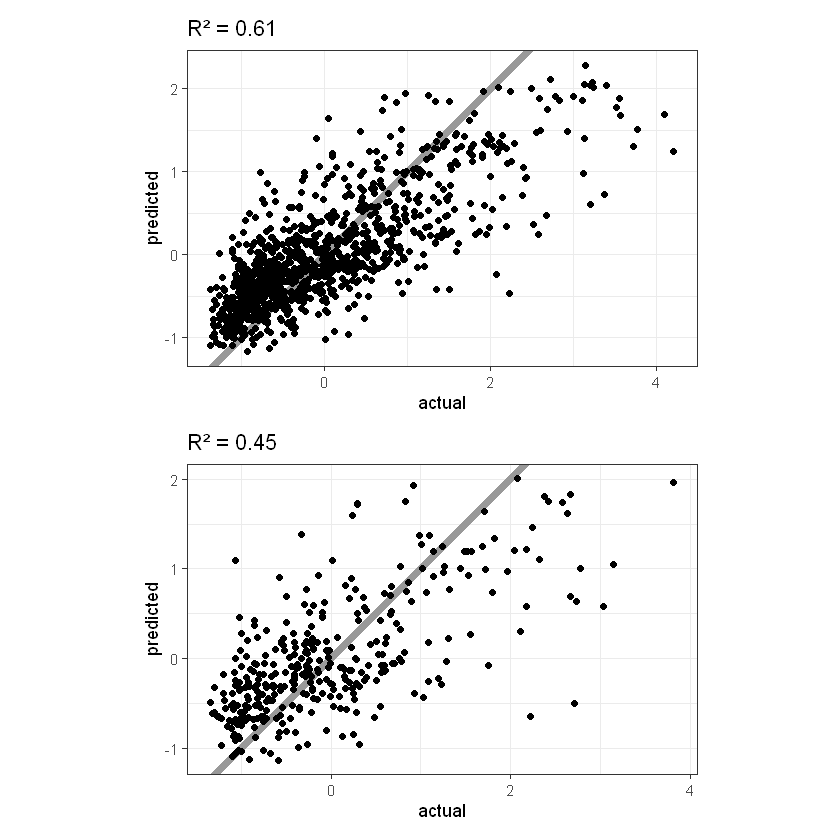

In [49]:
library("patchwork")

rsq_tr <- cor(train_baked$yield, predict(m_fit))^2
rsq_te <- cor(test_baked$yield, predict(m_fit, newdata = test_baked))^2

gg_tr <- tibble(actual = train_baked$yield,
       predicted = predict(m_fit)) %>%
  ggplot(aes(x = actual, y = predicted)) +
  geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
  geom_point() +
  labs(title = paste("R² =", round(rsq_tr, 2))) +
  theme_bw() +
  coord_equal()

gg_te <- tibble(actual = test_baked$yield,
       predicted = predict(m_fit, newdata = test_baked)) %>%
  ggplot(aes(x = actual, y = predicted)) +
  geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
  geom_point() +
  labs(title = paste("R² =", round(rsq_te, 2))) +
  theme_bw() +
  coord_equal()

gg_tr / gg_te

Importance of variables in the model.

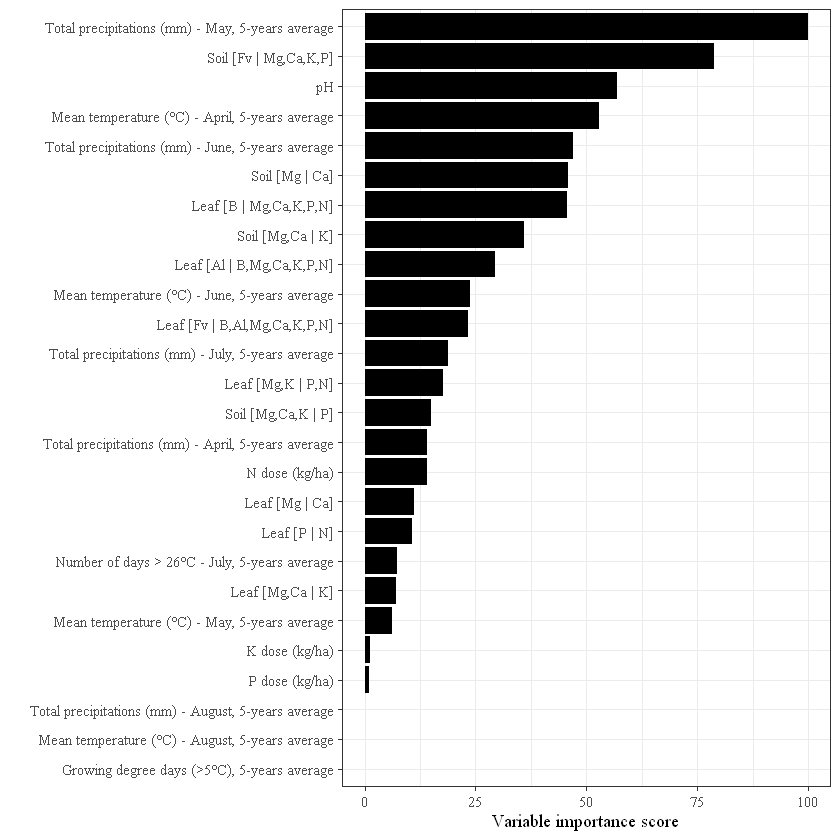

In [50]:
tibble(
  term = rownames(varImp(m_fit)$importance),
  score = varImp(m_fit)$importance[, 1]
) %>%
  left_join(translate_df, by = "term") %>%
  mutate(english = fct_reorder(factor(english), score)) %>%
  ggplot(aes(y = score, x = english)) +
  geom_bar(stat = "identity", fill = "black", lwd = 0) +
  labs(x = "", y = "Variable importance score") +
  coord_flip() +
  theme_bw() +
  theme(text=element_text(family="serif")) +
  ggsave("images/varimp.png", width = 6, height = 5, dpi = 300)

### Prediction model

Variable importance can't be assessed with Gaussian processes, which is a great tool to model smooth phenomenons like those occuring in agroecosystems (Coulibali et al. 2020).

In [51]:
tune_gp <- expand.grid( # gaussprRadial
  sigma = 0.1#c(0.05, 0.1, 0.15, 0.2)
)

m_fit <- train(yield ~ .,
               data = train_baked,
               method = "gaussprRadial",
               trControl = train_control,
               tuneGrid = tune_gp,
               verbose = FALSE
)

Create tables to plot observed vs predicted.

In [52]:
train_pred <- tibble(
  yield = npk_train$yield,
  pred = step_back(predict(m_fit, newdata = bake(npk_recipe, npk_train)))
)

test_pred <- tibble(
  yield = npk_test$yield,
  pred = step_back(predict(m_fit, newdata = bake(npk_recipe, npk_test)))
)

rsq_tr <- cor(train_pred$yield, train_pred$pred)^2
rsq_te <- cor(test_pred$yield, test_pred$pred)^2

Plot observed vs predicted.

Saving 6.67 x 6.67 in image



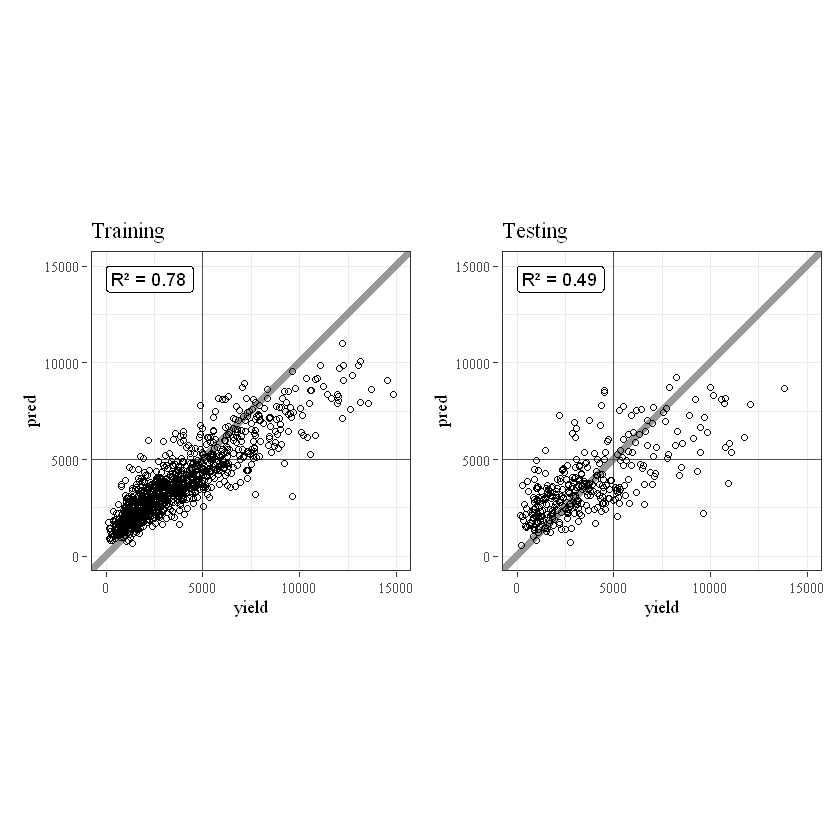

In [53]:
delimiter <- 5000
gg_pred_f <- function(data, rsq, title) {
  data %>%
    ggplot(aes(x = yield, y = pred)) +
    geom_abline(slope = 1, intercept = 0, colour = "gray60", lwd = 2) +
    geom_vline(xintercept = delimiter, colour = "gray30") +
    geom_hline(yintercept = delimiter, colour = "gray30") +
    geom_label(x = 0, y = 15000,
               vjust = 1, hjust = 0,
               label = paste("R² =", signif(rsq, 2))) +
    geom_point(pch = 1) +
    labs(title = title) +
    expand_limits(x = c(0, 15000), y = c(0, 15000)) +
    coord_equal() +
    theme_bw() +
    theme(text=element_text(family="serif"))
}

gg_training <- gg_pred_f(train_pred, rsq_tr, "Training")
gg_testing <- gg_pred_f(test_pred, rsq_te, "Testing")

gg_training + gg_testing

ggsave("images/modpred.png")

Binary classification.

In [54]:
delimiter <- 5000
test_bc <- test_pred %>%
  mutate(
    yield = case_when(
      yield >= delimiter ~ "HY",
      TRUE ~ "LY"
    ),
    pred = case_when(
      pred >= delimiter ~ "HY",
      TRUE ~ "LY"
    )
  )
test_cm <- table(test_bc)
print("Accuracy")
(test_cm[1, 1] + test_cm[2, 2]) / sum(test_cm)
print("PPV")
test_cm[2, 2] / sum(test_cm[2, ])
print("NPV")
test_cm[1, 1] / sum(test_cm[1, ])

[1] "Accuracy"


[1] 0.849711

[1] "PPV"


[1] 0.9348659

[1] "NPV"


[1] 0.5882353

# Predictive modelling usage on the ionome

We use a seed to assure reproducibility.

In [55]:
set.seed(956723) # random.org

We randomly sample a low performing site whose ionome should be investigated, extract its ionome and predict its yield.

In [56]:
misbal_observation <- df_npk %>% 
  filter(yield < 3000) %>% 
  sample_n(1)

ref_leaf <- misbal_observation %>% 
  select(starts_with("Leaf")) %>% 
  unlist()

yield_init <- step_back(predict(m_fit, newdata = bake(npk_recipe, misbal_observation)))

We set convergence parameters. `max_iter` is the number of steps in the Markov chain. The `radius` is the Aitchison distance where to scan around the point at each step. The initial radius, `radius[1]` is also the base radius, i.e. if a point with better yield is found, the radius goes back to this initial radius (`radius[1]`), else it is multiplied by `radius_factor` to enlarge scanning. Finally `n_rad` is the number of points to sample around the ionome of the preceeding step.

In [57]:
max_iter <- 10 
radius <- c(0.5)
radius_factor <- 1.25 # for adaptative search
radius_limits <- c(0.5, 1.5)
## if the max is too high, all explored ionome risk to be filtered out due
## to extrapolation (see Mahalanobis distance below). The upper limit
## should be set in relation to the p in qchisq below.
n_rad <- 5000

To scan around a point, we create a matrix with the number of columns defined by the number of balances in the ionome and the number of rows defined by `n_rad`, and fill it with random numbers. Each row is normalized to have a norm equal to the radius. 

To acheive the prediction, we need the ionome, but also other variables that are kept constant. This information is extracted in a table, then replicated `n_rad` times to be binded further on to the perturbed ionomes scanned around the best ionome.

In [58]:
misbal_observation_noleaf <- misbal_observation %>% 
  select(-starts_with("Leaf")) 
misbal_observation_noleaf_stacked <- do.call(
  "rbind",
  replicate(n_rad, misbal_observation_noleaf, simplify = FALSE)
)

We initialize the yield and the ionome.

In [59]:
ref_yield <- c(yield_init)
ref_leaf <- matrix(ncol = nrow(sbp_leaf), nrow = max_iter)

ref_leaf[1, ] <- misbal_observation %>% 
  select(starts_with("Leaf")) %>% 
  unlist()

We use a mahalanobis distance to ensure that the algorithm doesn't explore too far from the theoretical multivariate normal distribution of the ionome. To compute the Mahalanobis distance, we need the mean, the (invert) covariance and a critical (squared) distance.

In [60]:
bal_mean <- apply(bal_leaf %>% select(-id), 2, mean)
bal_icov <- solve(cov(bal_leaf %>% select(-id)))
crit_dist <- qchisq(p = 0.999, df = length(bal_mean))

... and fire the Markov chain.

[1] "Iteration 2 - yield improvement to 5066.87452741718"
[1] "Iteration 3 - yield improvement to 5699.56541234905"
[1] "Iteration 4 - yield improvement to 5853.78395603872"
[1] "Iteration 5 - no yield improvement."
[1] "Iteration 6 - no yield improvement."
[1] "Iteration 7 - no yield improvement."
[1] "Iteration 8 - no yield improvement."
[1] "Iteration 9 - no yield improvement."
[1] "Iteration 10 - out of the hyperellipsoid."


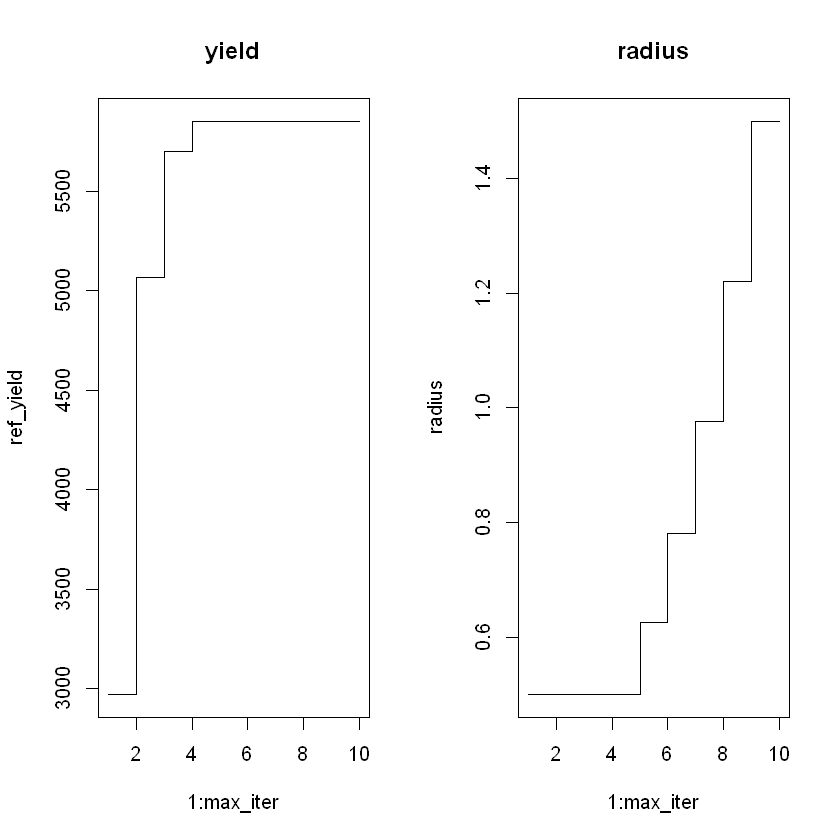

In [61]:
for (i in 2:max_iter) {
  # print(paste(i, "/", max_iter))
  offset <- matrix(runif(ncol(ref_leaf) * n_rad, -1, 1), 
                   ncol = ncol(ref_leaf),
                   nrow = n_rad)
  offset <- t(apply(offset, 1, function(x) radius[i-1] * x / sqrt(sum(x^2))))
  leaf_search <- t(apply(offset, 1, function(x) x + ref_leaf[i-1, ] ))
  
  # Compute the Mahalanobis distance
  maha_dist <- mahalanobis(leaf_search, bal_mean, bal_icov, inverted = TRUE)
  # filter out search ionomes outside the Mahalanobis distance limit
  leaf_search <- data.frame(leaf_search) %>% filter(maha_dist < crit_dist)
  
  names(leaf_search) <- paste0("Leaf_", leaf_bal_def)
                         
  df_search <- leaf_search %>% 
    bind_cols(misbal_observation_noleaf_stacked %>% filter(maha_dist < crit_dist))
    
  if(nrow(df_search) == 0) { # if no points are generated in the hyper ellipsoid, keep the reference but increase radius
    print(paste("Iteration", i, "- all points are out of the hyperellipsoid."))
    ref_yield[i] <- ref_yield[i-1]
    ref_leaf[i, ] <- ref_leaf[i-1, ]
    # increase the radius
    radius[i] <- radius[i - 1] * radius_factor
    radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
    radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
  } else {
    # Compute predicted yield
    yield_stochastic <- step_back(predict(m_fit, newdata = bake(npk_recipe, df_search)))
    if(max(yield_stochastic) > ref_yield[i-1]) {
      print(paste("Iteration", i, "- yield improved to", max(yield_stochastic)))
      ref_yield[i] <- max(yield_stochastic)
      ref_leaf[i, ] <- leaf_search[which.max(yield_stochastic), ] %>% 
        unlist()
      # decrease the radius
      radius[i] <- radius[i - 1] / radius_factor
      radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
    } else {
      print(paste("Iteration", i, "- no yield improvement."))
      ref_yield[i] <- ref_yield[i-1]
      ref_leaf[i, ] <- ref_leaf[i-1, ]
      # increase the radius
      radius[i] <- radius[i - 1] * radius_factor
      radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
      radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
    }
  }
}

par(mfrow = c(1, 2))
plot(1:max_iter, ref_yield, type = 's', main = "yield")
plot(1:max_iter, radius, type = 's', main = "radius")

At each step, balances are transformed back to the concentration scale.

In [62]:
ref_leaf_comp <- ilrInv(ref_leaf,
                        V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()

We then create a decent table able to be plotted.

In [63]:
gg_iter <- bind_cols(
  ref_leaf_comp,
  tibble(yield = ref_yield, iteration = 1:max_iter)
) %>% 
  pivot_longer(
    cols = -iteration,
    names_to = "variables",
    values_to = "values"
  ) %>% 
  mutate(values = case_when(variables != "yield" ~ values * 100,
                            TRUE ~ values), # concentrations in %
         units = case_when(variables == "yield" ~ "kg/ha",
                           TRUE ~ "%")) # units

We extract points obtained at the first iteration and at the end to plot points and labels.

In [64]:
gg_iter_extremes <- gg_iter %>% 
  filter(iteration %in% c(1, max_iter))

The following block extracts min and max of the concentrations in the training set.

In [65]:
bal_train <- npk_train %>% 
  select(starts_with("Leaf")) 
comp_train <- ilrInv(bal_train, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame()
comp_range <- comp_train %>% 
  mutate(id_tr = 1:nrow(.)) %>% 
  pivot_longer(cols = -id_tr, names_to = "variables",
               values_to = "value") %>% 
  group_by(variables) %>% 
  summarise(min = min(value),
            max = max(value)) %>% 
  pivot_longer(cols = -variables,
               names_to = "statistic",
               values_to = "value") %>% 
  mutate(value = value * 100)

And plot with a lot of pretty theming.

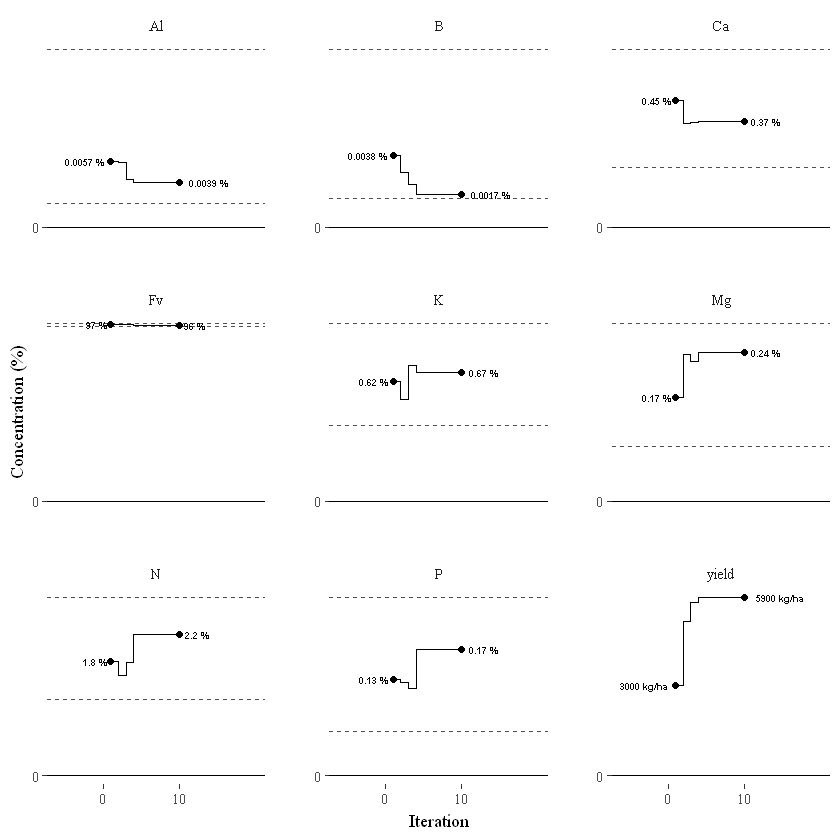

In [66]:
ggplot(gg_iter, aes(x = iteration, y = values)) +
  facet_wrap(~variables, scales = "free_y", ncol = 3) +
  geom_hline(data = comp_range,
             aes(group = statistic, yintercept = value),
             colour = "gray30", linetype = 2, lwd = 0.2) +
  geom_step() +
  geom_point(data = gg_iter_extremes) +
  geom_text(data = gg_iter_extremes %>% filter(iteration == 1), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = 1.15, 
            fontface = "bold", 
            size = 2) +
  geom_text(data = gg_iter_extremes %>% filter(iteration == max_iter), 
            aes(label = paste(signif(values, 2), units)), 
            hjust = -0.25, 
            fontface = "bold", 
            size = 2) +
  geom_hline(yintercept = 0) +
  expand_limits(x = c(-6, 20), y = 0) +
  scale_x_continuous(breaks = seq(0, max_iter, by = 10)) +
  labs(x = "Iteration", y = "Concentration (%)") +
  scale_y_continuous(breaks=0) +
  theme_bw() +
  theme(
    panel.spacing = unit(10, 'mm'),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    strip.background = element_blank(),
    panel.grid.major.x = element_blank(),
    text = element_text(family = "serif")
  ) +
  ggsave("images/convergence.png", height = 4, width = 6, dpi = 300)

Aitchison distance between observed and target.

In [67]:
sqrt(sum((ref_leaf[1, ] - ref_leaf[max_iter, ]) ^ 2))

[1] 1.0042

Visualisation of the observed/target ratio.

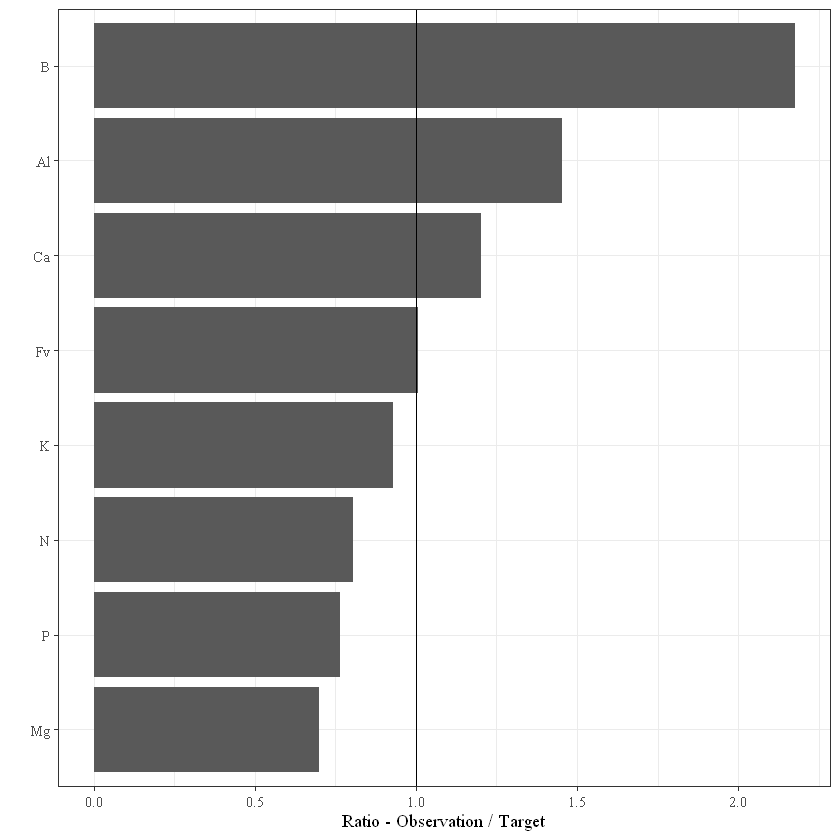

In [68]:
gg_iter_extremes %>%
  pivot_wider(names_from = iteration,
              values_from = values) %>% 
  mutate(ratio = `1` / `10`) %>% 
  filter(variables != "yield") %>% 
  mutate(variables = fct_reorder(variables, ratio)) %>% 
  ggplot(aes(y = ratio, x = variables)) +
  labs(x = "", y = "Ratio - Observation / Target") +
  geom_col() +
  geom_hline(yintercept = 1) +
  coord_flip() +
  theme_bw() +
  theme(text = element_text(family = "serif")) +
  ggsave("images/ratio.png", height = 2, width = 4, dpi = 300)

# Overview of optimal ionomes

The same code is applied to all observations in an external file to obtain overall statistics of targets.

In [69]:
source("lib/donkey-tail.R")

[1] "row 1 of 1384"
[1] "row 2 of 1384"
[1] "row 3 of 1384"
[1] "row 4 of 1384"
[1] "row 5 of 1384"
[1] "row 6 of 1384"
[1] "row 7 of 1384"
[1] "row 8 of 1384"
[1] "row 9 of 1384"
[1] "row 10 of 1384"
[1] "row 11 of 1384"
[1] "row 12 of 1384"
[1] "row 13 of 1384"
[1] "row 14 of 1384"
[1] "row 15 of 1384"
[1] "row 16 of 1384"
[1] "row 17 of 1384"
[1] "row 18 of 1384"
[1] "row 19 of 1384"
[1] "row 20 of 1384"
[1] "row 21 of 1384"
[1] "row 22 of 1384"
[1] "row 23 of 1384"
[1] "row 24 of 1384"
[1] "row 25 of 1384"
[1] "row 26 of 1384"
[1] "row 27 of 1384"
[1] "row 28 of 1384"
[1] "row 29 of 1384"
[1] "row 30 of 1384"
[1] "row 31 of 1384"
[1] "row 32 of 1384"
[1] "row 33 of 1384"
[1] "row 34 of 1384"
[1] "row 35 of 1384"
[1] "row 36 of 1384"
[1] "row 37 of 1384"
[1] "row 38 of 1384"
[1] "row 39 of 1384"
[1] "row 40 of 1384"
[1] "row 41 of 1384"
[1] "row 42 of 1384"
[1] "row 43 of 1384"
[1] "row 44 of 1384"
[1] "row 45 of 1384"
[1] "row 46 of 1384"
[1] "row 47 of 1384"
[1] "row 48 of 1384"
[

In [70]:
save(opt_bal, opt_yield, ait_dist, file = "output/opt.RData")

In [71]:
load("output/opt.RData")

variable,min,q25,median,q75,max
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N,1.339020240,1.814534456,2.010939428,2.204599155,3.14539303
P,0.062727281,0.125535814,0.141189753,0.161899884,0.27661015
K,0.359831595,0.550277218,0.615407829,0.695457027,1.09525692
Ca,0.219479226,0.348311422,0.400000000,0.462145966,0.78243639
Mg,0.089309578,0.157068055,0.176146909,0.197764309,0.33038634
B,0.001122185,0.002536430,0.003917641,0.004875066,0.01300946
Al,0.002106753,0.004313511,0.005421540,0.006892018,0.01708912
Fv,95.375376577,96.371931040,96.638409220,96.874162888,97.55452850


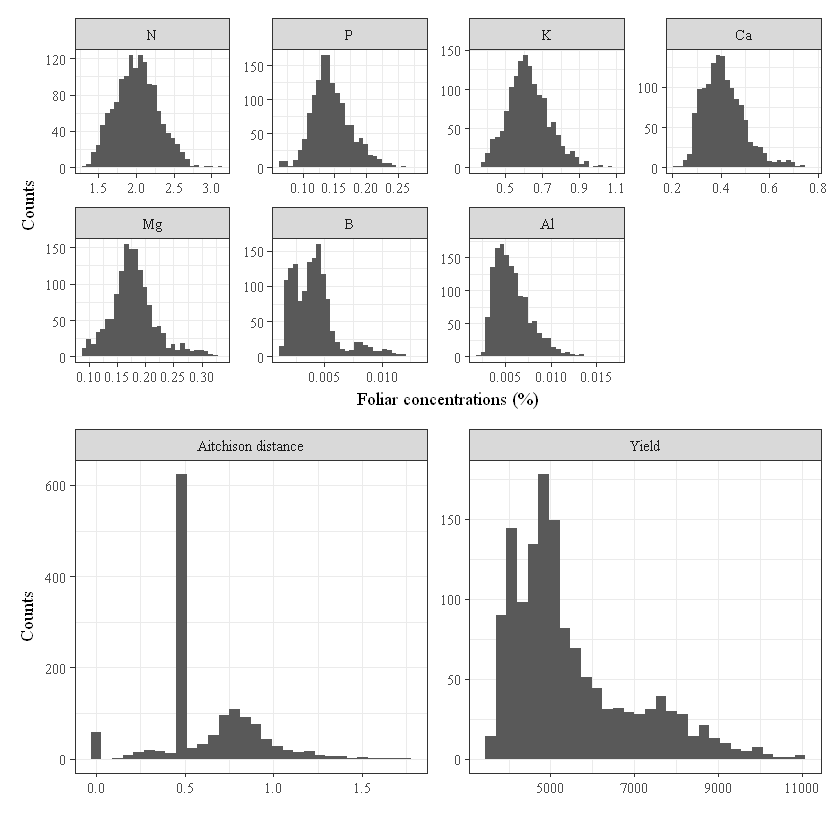

In [72]:
opt_comp <- ilrInv(opt_bal, V = gsi.buildilrBase(t(sbp_leaf))) %>% 
  data.frame() %>% 
  mutate(id = 1:nrow(opt_bal)) %>% 
  pivot_longer(cols = -c(id),
               names_to = "variable", values_to = "value") %>% 
  mutate(value = value * 100,
         variable = factor(variable, levels = c("N", "P", "K", "Ca", "Mg", "B", "Al", "Fv")))

opt_output <- tibble(id = 1:nrow(opt_bal),
                     Yield = opt_yield[, 2],
                     `Aitchison distance` = ait_dist) %>% 
  pivot_longer(cols = -c(id),
               names_to = "variable", values_to = "value")

opt_comp_gg <- opt_comp %>% 
  filter(variable != "Fv") %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 2, scales = "free") +
  geom_histogram(bins = 30) +
  labs(x = "Foliar concentrations (%)", y = "Counts") +
  theme_bw() +
  theme(text = element_text(family = "serif"))

opt_out_gg <- opt_output %>% 
  ggplot(aes(x = value)) +
  facet_wrap(~variable, nrow = 1, scales = "free") +
  geom_histogram(bins = 30) +
  labs(x = "", y = "Counts") +
  theme_bw() +
  theme(text = element_text(family = "serif"))

opt_comp_gg / opt_out_gg
ggsave("images/opt-distr.png", height = 10, width = 10, dpi = 300)

opt_comp %>% 
  group_by(variable) %>% 
  summarise(min = min(value),
            q25 = quantile(value, prob = 0.25),
            median = median(value),
            q75 = quantile(value, prob = 0.75),
            max = max(value))

In [70]:
df_source %>% 
  select(id, starts_with("Leaf")) %>% 
  pivot_longer(cols = -id, names_to = "variable", values_to = "value") %>% 
  group_by(variable) %>% 
  summarise(min = min(value, na.rm = TRUE),
            max = max(value, na.rm = TRUE))

variable,min,max
<chr>,<dbl>,<dbl>
Leaf Al (ppm),21.00,155.40
Leaf B (ppm),15.00,94.40
Leaf Ca (%),0.21,0.63
Leaf Cu (ppm),1.21,9.30
Leaf Fe (ppm),8.40,54.20
Leaf K (%),0.39,0.92
Leaf Mg (%),0.09,0.29
Leaf Mn (ppm),154.00,298.00
Leaf Mo (ppm),0.00,0.65
